# **House Price Prediction Data Analysis and Preprocess**
## Team Name: TeamMoyu
### Members: Shihong Ling, Shaoheng Lai, Xincheng Zhang

# **Part 0 Overview**
Our final report cosists of 5 parts: in part 0, we will generally introduce each part's content; in part 1, we will show our process of data exporation and findings during exploring; in part 2, we will show our ideas about how to do data preprocessing, feature engineering, and  overfitting/underfitting limitation, and also our findings during this process; in part 3, we will show our experiments with different models and our findings; in part 4, we summary all the code we have and create several convinient methods for you to run to get our final submission.

Here is our final project video link: https://www.youtube.com/watch?v=MXyTD88va8M (If the link does not work, you can directly watch the attached video)

**!!!Warning!!!**: The following healper method and any code in Part 1 and Part 2 are only used to generate graphs for us to make analysis and discussion during data exploration and feature engineering. We have already run them and get wanted graphs in Google Colab! There is no need to run them again. And also, since there are some conflicts between Colab and Jupyter, the codes downloaded from Colab cannot run correctly in Jupyter! Please only run our perfectly summarized methods in Part 4! Thanks for understanding :)





In [14]:
# This is only used to show our efforts, plz don't run!
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

# Produce graphs before and after processing
def process_data(show="none"):
    global train
    global test
    global y_train
    global train_ID
    global test_ID
    global fig_heatmap
    global figure_price

    # load data
    train = pd.read_csv('train.csv')

    #correlation graph
    if show=="pre_corr":
      df_num = train.select_dtypes(include=['float64', 'int64'])
      for i in range(0, len(df_num.columns), 5):
          sns.pairplot(data=df_num,
                      x_vars=df_num.columns[i:i + 5],
                      y_vars=['SalePrice'])
          
      plt.show()
      return

    #check NA
    if show=="pre_checkna":
      train.info()

    train_ID = train['Id']

    # print(train['SalePrice'].describe())
    if show=="pre_salesprice":
      plt.figure(figsize=(9, 8))
      figure_price=sns.distplot(train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})
      return

    # numeric graph
    quantitative_features_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']
    if show=="pre_heat":
      corr_new_train=train.corr()
      plt.figure(figsize=(5,15))
      sns.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
      sns.set(font_scale=2)
      return

    if show=="pre_cate":
      df=train
      categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]
      df_categ = df[categorical_features]
      df_not_num = train[categorical_features]
      fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))

      for i, ax in enumerate(fig.axes):
          if i < len(df_not_num.columns):
              ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
              sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
      fig.tight_layout()
      return 
    
    # drop ID feature
    train.drop('Id', axis=1, inplace=True)

    # analyze and remove huge outliers: GrLivArea, ...
    train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

    # normalize distribution of output (SalePrice)
    train["SalePrice"] = np.log1p(train["SalePrice"])

    if show=="after_salesprice":
      plt.figure(figsize=(9, 8))
      figure_price=sns.distplot(train['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4})
      return

    # concatenate the train and test data
    all_data = train

    # fill missing data
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]


    all_data["PoolQC"] = all_data["PoolQC"].fillna(
        "None")  # data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")  # data description says NA means "no misc feature"
    all_data["Alley"] = all_data["Alley"].fillna("None")  # data description says NA means "no alley access"
    all_data["Fence"] = all_data["Fence"].fillna("None")  # NA means "no fence"
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")  # NA means "no fireplace"
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(
        x.median()))  # fill by the median LotFrontage of all neighborhood because they have same lot frontage
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None')  # NaN means that there is no basement
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")  # NA means no masonry veneer
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)  # NA means no masonry veneer
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'],
                             axis=1)  # For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it
    all_data["Functional"] = all_data["Functional"].fillna("Typ")  # data description says NA means typical
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[
                                                               0])  # It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[
                                                                 0])  # Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[
                                                                 0])  # Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[
                                                                 0])  # Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['SaleType'] = all_data['SaleType'].fillna(
        all_data['SaleType'].mode()[0])  # Fill in again with most frequent which is "WD"
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna(
        "None")  # Na most likely means No building class. We can replace missing values with None

    # add important features more
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data[
        '2ndFlrSF']  # feature which is the total area of basement, first and second floor areas of each house

    # normalize skewed features
    for feature in all_data:
        if all_data[feature].dtype != "object":
            all_data[feature] = np.log1p(all_data[feature])

    # transform numeric features into categorical features
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['OverallQual'] = all_data['OverallQual'].astype(str)
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)

    # encode categorical features by LabelEncoder or dummies
    categorical_features = \
        ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
         'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual',
         'OverallCond', 'YrSold', 'MoSold')
    for feature in categorical_features:
        label = LabelEncoder()
        label.fit(list(all_data[feature].values))
        all_data[feature] = label.transform(list(all_data[feature].values))
    # get dummy categorical features
    all_data = pd.get_dummies(all_data)

    if show=="after_heat":
      corr_new_train=train.corr()
      plt.figure(figsize=(5,15))
      sns.heatmap(corr_new_train[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
      sns.set(font_scale=2)
      return



# **Part 1 Data analyzing**

Before we move on to test different models with the training data, we first need to perform a data analysis. 

## **1.1 Dropping features**
By watching the scatter plots for each feature vs SalePrice, we find some features are totally useless. So We gonna do further research on them and to see whether we should drop those features.

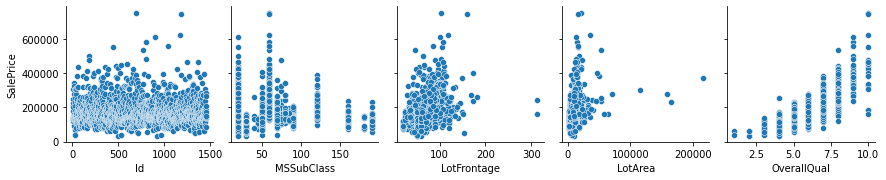

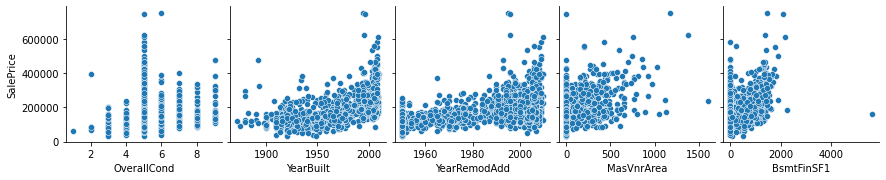

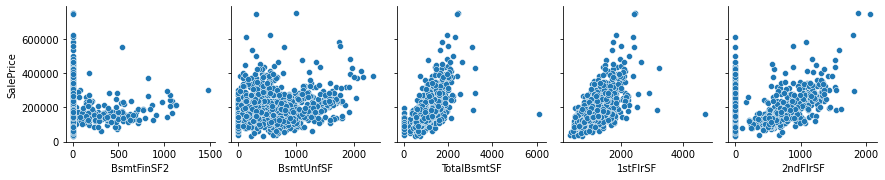

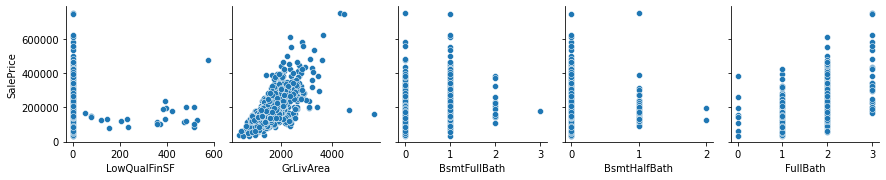

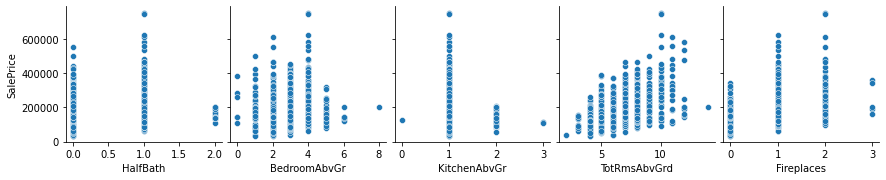

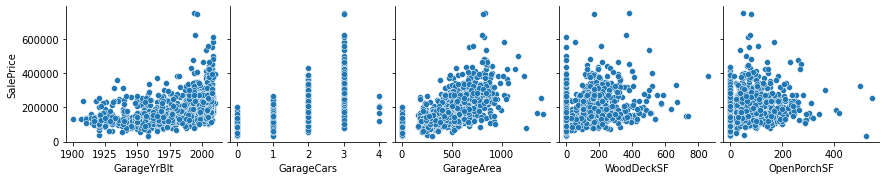

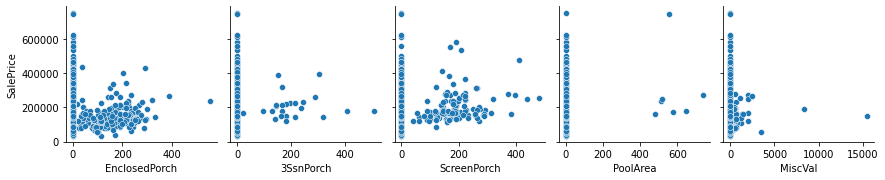

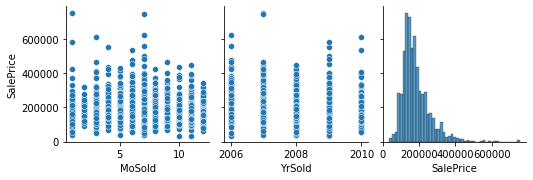

In [9]:
#please run the code cell at the end of the report first to view the graph
process_data(show="pre_corr")

After observation, we first decide to drop "ID" which obvious has no relationship with saleprice.

## **1.2 Numeric features**

Except useless features, through scatter plots, we also notice that many numeric features (including our label SalePrice) have bad skewness and kurtosis. In order to prepare data with normal distribution for our model, we may need to normalize those features whose distribution have too large skewness. Here we use SalePrice as an example to show what the bad distribution looks like:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


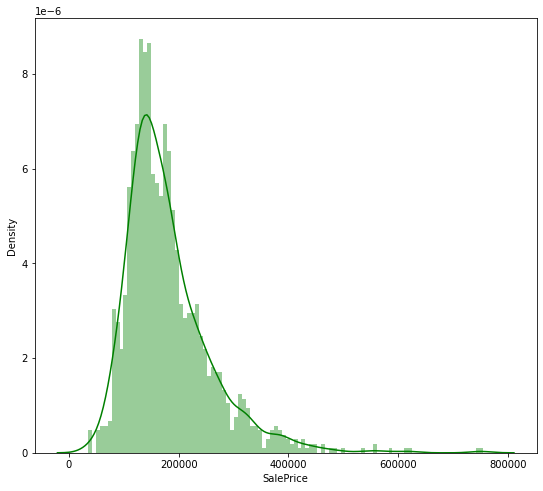

In [10]:
process_data(show="pre_salesprice")


## **1.3 Outliers**
We also need to deal with these outliers data. By looking at the scatter plots of SalePrice, we can easily see that there exist some outliers which have price over 500,000 (such as GrLiveArea). We need to take some measurements for them in feature engineering.

## **1.5 Missing values**
There are a lot of features which have NaN values in the dataset. Some of them have a lot of losses, while some of them have just a few. At beigining, we cosider to drop those features that have big losses. However, based on data description, we find that many of those big-loss features have special meanings in NaN. So we should substitute those who have special meanings (such as PoolQC and MiscFeature) with other appropriate values. As for those small-loss features, we may replace those missing values with mean, medium, or mode value.

In [11]:
process_data(show="pre_checkna")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

From the correlation between features and features we learn that some numerical features are heavily correlated with other features. We can combine them to reduce the number of features.

## **1.6 Categorical features**

Next, we move to visualize categorical features in order to see whether they need any processing:

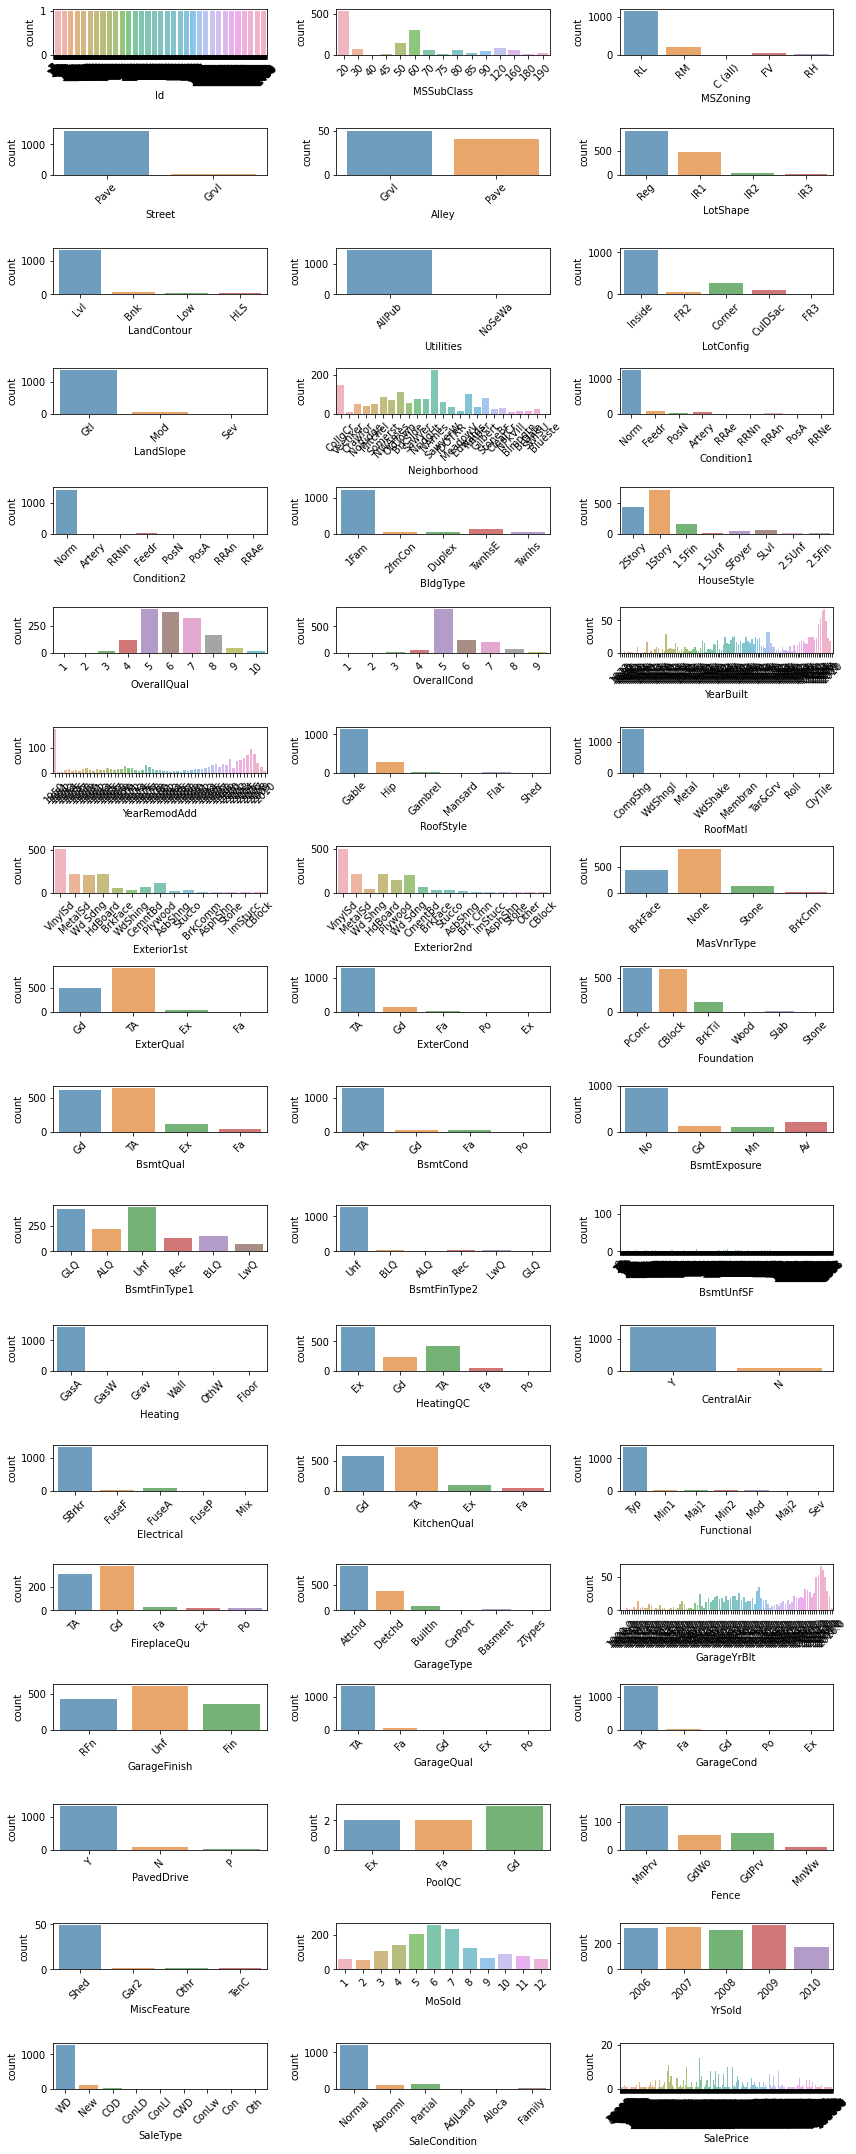

In [7]:
process_data("pre_cate")

Afer observing the plots of categorical features, we can see that some values are predominant for some features such as `Utilities`. These features may not be helpful for our model. We should deal with it in later procedure. In addition, we also notice that some features have so many complex categories (such as years) that we may simplify for them in the future.

## **1.7 Correlation Review**

Finally, we make a overall review to see the correlation between each feature and target SalePrice in original dataset. This will be compared with the correlation graph after preprocessing and feature engineering to show how well our work is.

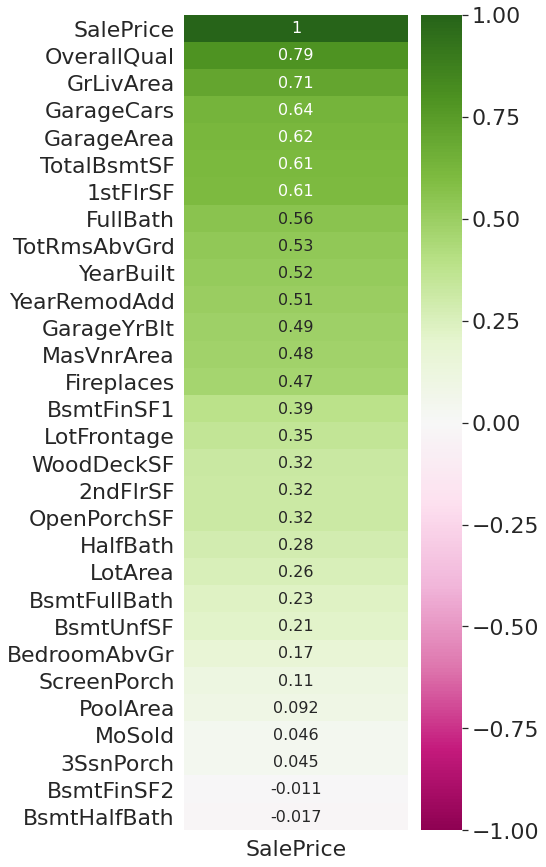

In [16]:
process_data("pre_heat")

# **Part 2 Data preprocessing and feature engineering**

**!!!Notice!!!**: The order in which we solve the problems found in data exporation is different from Part 1. So don't be confused. :)


##**2.1 Dropping features**<br>
<br>**2.2.1** For the feature "Id" has no predictive power, we can safely remove it.<br>
<br>**2.2.2** In the feature 'Utilities', all values are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.<br>



##**2.2 Missing values**
To deal with missing values is a more complicated situation. After reading data description, we know that NA in data means different thing in different features. We have to deal with each feature manually. 
<br>
<br>"NA" in "PoolQC" means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.We replace "NA" with string "None" to indicates there is no pool for this example.<br>
<br>"NA" in "MiscFeature" means "no misc feature". Replace it with "None".<br>
<br>"NA" in "Alley" means "no alley access". Replace it with "None". <br>
<br>"NA" in "Fence" means "no fence". Replace it with "None". <br>
<br>"NA" in "FireplaceQu" means "no fireplace". Replace it with "None". <br>
<br>"NA" in 'GarageType',  'GarageFinish',  'GarageQual', 'GarageCond', 'GarageYrBlt',  'GarageArea',  'GarageCars' all mean "no garage". Replace it with "None". <br>
<br> "NA" in 'BsmtFinSF1', 'BsmtFinSF2',  'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',  'BsmtHalfBath' mean "No basement". Replace it with "None".<br>
 <br>"NA" in "MasVnrType" and "MasVnrArea" means no masonry veneer. Replace it with "None". <br>
<br>"NA" in "Functional" means "typical". Replace it with "Typ". <br>
<br>"Electrical" has only one "NA". Since this feature has mostly 'SBrkr', we can set that for the missing value.<br>
<br>'KitchenQual' has only one "NA". We can set that for the missing value.<br>
<br>'Exterior1st' and 'Exterior2nd' has only one "NA". We replace it with most common values.<br>
<br>'SaleType' has only one "NA". Fill in with most common value. <br>
<br>"NA" in "MSSubClass" means No building class. We can replace missing values with None.<br>
<br>




##**2.3 Combining features**<br>
We add a feature 'TotalSF' which is the total area of basement, first and second floor areas of each house. TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF. We can do so because from the heatmap in 1.6 we know that these three features are largely correlated. <br>


##**2.4 Special numeric features**<br>
There are some special numeric features. Although they have number as values, the values itself work as a label. For example, the number of years and the scales of quality. <br>
<br>Therefore, we convert 'YrSold' and 'MoSold' to string for they are number of years. Also, we convert 'OverallCond','OverallQual' and 'MSSubClass' to string for they mean scales. 

##**2.5 Outliers**<br>
Extreme values that fall a long way outside of the other observations should be considered outliers. After anlyzing all numeric values, we consider GrLivArea larger than 4000 and SalePrice smaller than 300,000 to be outliers. The decision is based on both majority of obsevations and common sense.

## **2.6 Skewness**
Since we already knew in part 1 that the data is heavily skewed, we apply logarithm to all numeric features.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


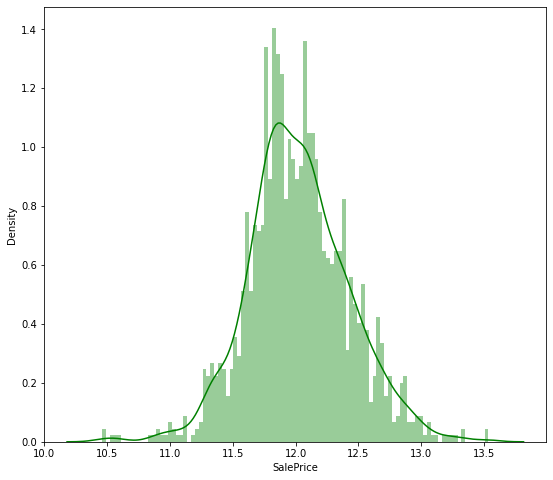

In [ ]:
process_data(show="after_salesprice")

After applying logarithm and it, the data now becomes normally distributed.

##**2.7 Overfitting Prevention**<br>

Removing features 'ID' reduce the risk of Overfitting since this feature only 
related to trainning data but does not provide any predictive information for testing data.

##**2.8 Categorical transformation**<br>
After dealing with missing values and special features, we can convert all categorical features to numeric features. We use LabelEncoder in sklearn and get_dummies() in pandas to do so.  

## **2.9 Correlation review**

After all these preprocessing and feature engineering, let us have a look at the correlation between each feature and target SalePrice in our new dataset:

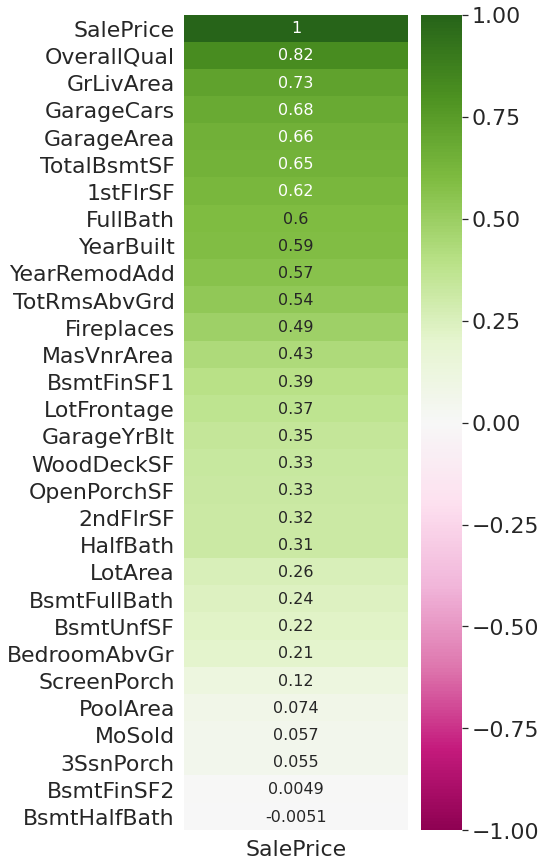

In [15]:
process_data("after_heat")

Through our preprocessing and feature engineering, obviously, we improve all features' correlation toward target SalePrice, and even add a few more important features which can help.

## Part 3 Training Models

After data preprocessing and feature engineering, we get our ideal train and test dataset. Now it is time to create models for them.

We first choose 6 models that are generally good for regression in our mind: Lasso, Elastic Net, Kernal Ridge, Gradient Boosting, XGBoost, and LightGBM. In order to decide which model performs better, we use K-fold cross validation to evaluate them. First of all, we need to import necessary packages for analysis and prepare processed datasets:

In [3]:
# Import necessary packages
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
# Follow the data processing and feature engineering part, make the train & test sets for model analysis

train_for_model_analysis = pd.read_csv('train.csv')
test_for_model_analysis = pd.read_csv('test.csv')

train_for_model_analysis.drop('Id', axis = 1, inplace = True)
test_for_model_analysis.drop('Id', axis = 1, inplace = True)

train_for_model_analysis = train_for_model_analysis.drop(train_for_model_analysis[(train_for_model_analysis['GrLivArea']>4000) & (train_for_model_analysis['SalePrice']<300000)].index)
train_for_model_analysis["SalePrice"] = np.log1p(train_for_model_analysis["SalePrice"])
y_for_model_analysis = train_for_model_analysis.SalePrice.values

split_index = train_for_model_analysis.shape[0]
train_for_model_analysis.drop(['SalePrice'], axis=1, inplace=True)
train_test = pd.concat((train_for_model_analysis, test_for_model_analysis)).reset_index(drop=True)

# Fill missing & delete useless 
train_test["PoolQC"] = train_test["PoolQC"].fillna("None") #data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
train_test["MiscFeature"] = train_test["MiscFeature"].fillna("None") #data description says NA means "no misc feature"
train_test["Alley"] = train_test["Alley"].fillna("None") #data description says NA means "no alley access"
train_test["Fence"] = train_test["Fence"].fillna("None") #NA means "no fence"
train_test["FireplaceQu"] = train_test["FireplaceQu"].fillna("None") #NA means "no fireplace"
train_test["LotFrontage"] = train_test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))  # fill by the median LotFrontage of all neighborhood because they have same lot frontage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train_test[col] = train_test[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train_test[col] = train_test[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train_test[col] = train_test[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train_test[col] = train_test[col].fillna('None') #NaN means that there is no basement
train_test["MasVnrType"] = train_test["MasVnrType"].fillna("None") #NA means no masonry veneer
train_test["MasVnrArea"] = train_test["MasVnrArea"].fillna(0) #NA means no masonry veneer
train_test['MSZoning'] = train_test['MSZoning'].fillna(train_test['MSZoning'].mode()[0])
train_test = train_test.drop(['Utilities'], axis=1) #For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it
train_test["Functional"] = train_test["Functional"].fillna("Typ") #data description says NA means typical
train_test['Electrical'] = train_test['Electrical'].fillna(train_test['Electrical'].mode()[0]) #It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
train_test['KitchenQual'] = train_test['KitchenQual'].fillna(train_test['KitchenQual'].mode()[0]) #Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual
train_test['Exterior1st'] = train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
train_test['Exterior2nd'] = train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
train_test['SaleType'] = train_test['SaleType'].fillna(train_test['SaleType'].mode()[0]) #Fill in again with most frequent which is "WD"
train_test['MSSubClass'] = train_test['MSSubClass'].fillna("None") #Na most likely means No building class. We can replace missing values with None
    
# add important features more
train_test['TotalSF'] = train_test['TotalBsmtSF'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] #feature which is the total area of basement, first and second floor areas of each house
    
# normalize skewed features
for feature in train_test:
    if train_test[feature].dtype != "object":
        train_test[feature] = np.log1p(train_test[feature])
                
# transform numeric features into categorical features
train_test['MSSubClass'] = train_test['MSSubClass'].apply(str)
train_test['OverallQual'] = train_test['OverallQual'].astype(str)
train_test['OverallCond'] = train_test['OverallCond'].astype(str)
train_test['YrSold'] = train_test['YrSold'].astype(str)
train_test['MoSold'] = train_test['MoSold'].astype(str)
    
# encode categorical features by LabelEncoder or dummies
categorical_features = \
('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
    'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
    'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
    'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual',
    'OverallCond', 'YrSold', 'MoSold')
for feature in categorical_features:
    label = LabelEncoder() 
    label.fit(list(train_test[feature].values))
    train_test[feature] = label.transform(list(train_test[feature].values))
# get dummy categorical features
train_test = pd.get_dummies(train_test)

# split back to train and test
train_for_model_analysis = train_test[:split_index]
test_for_model_analysis = train_test[split_index:]

Then we make a K-Fold Cross Validation helper method and will use it evaluate chosen models. This helper method has 5 folds and returns cross validation score's mean and standard devition values. Currently, we do not set up any parameters for these 6 models, we will test different parameters and show the best combo in the next step.

In [4]:
# Helper method for calculating K-fold cross validation
n_folds = 5
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_for_model_analysis.values)
    rmse= np.sqrt(-cross_val_score(model, train_for_model_analysis.values, y_for_model_analysis, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso())
score = rmse_cv(lasso)
print('[model] ', "Lasso score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet())
score = rmse_cv(ENet)
print('[model] ', "ElasticNet score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Kernel Ridge Regression
KRR = KernelRidge()
score = rmse_cv(KRR)
print('[model] ', "Kernel Ridge score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor()
score = rmse_cv(GBoost)
print('[model] ', "Gradient Boosting score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# XGBoost 
model_xgb = xgb.XGBRegressor()
    
score = rmse_cv(model_xgb)
print('[model] ', "Xgboost score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# LightGBM 
model_lgb = lgb.LGBMRegressor()
score = rmse_cv(model_lgb)
print('[model] ', "LGBM score(cv): {:.4f} ({:.4f})" .format(score.mean(), score.std()))

[model]  Lasso score(cv): 0.3782 (0.0130)
[model]  ElasticNet score(cv): 0.3781 (0.0126)
[model]  Kernel Ridge score(cv): 0.1180 (0.0087)
[model]  Gradient Boosting score(cv): 0.1200 (0.0066)
[model]  Xgboost score(cv): 0.1307 (0.0056)
[model]  LGBM score(cv): 0.1275 (0.0059)


Without parameters, Lasso and Elastic Net regression model have very bad performances, while the other 4 models have common performances. Up to now, it seems kernel ridge is the best model, however, if we adjust their parameters, we may have different result. So we start to find the appropriate parameters for them. 

We have two steps to achieve our goal: first step is to use parameter tunning method (for example, GridSearchCV) to find a good value for target parameter; second step is to select and try manually several values around the good value of a parameter given by the function. And the reason why we do this second step is that we find sometimes the good parameters calculated by method are not the best in real using. Here we show some examples:

In [5]:
from numpy import arange

# Example 1: Lasso, a simple example
lasso_example = Lasso(random_state=1)
grid_lasso = dict()
grid_lasso['alpha'] = arange(0, 0.001, 0.0001)
lasso_search = GridSearchCV(lasso_example, grid_lasso, scoring='neg_mean_absolute_error', cv=5, n_jobs=1)
lasso_search_result = lasso_search.fit(train_for_model_analysis, y_for_model_analysis)
print('Parameter Suggestion for alpha: %s' % lasso_search_result.best_params_)


# Example 2: xgboost, a complex example
grid_xgb = dict()
grid_xgb['colsample_bytree'] = [0.2, 0.3, 0.4]
grid_xgb['gamma'] = [0.2, 0.3, 0.4]
grid_xgb['learning_rate'] = [0.01, 0.05, 0.1]
grid_xgb['depth'] = [3, 4, 5]
xgb_example_model = xgb.XGBRegressor()
xgb_search = GridSearchCV(xgb_example_model, grid_xgb, cv = 5, n_jobs = 1)
xgb_search_result = xgb_search.fit(train_for_model_analysis,y_for_model_analysis)
print('Parameter Suggestion for xgb: %s' % xgb_search_result.best_params_)

Parameter Suggestion for alpha: {'alpha': 0.00030000000000000003}
[18:29:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XG

[18:29:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:29:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:29:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:29:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:29:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:30:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:30:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

[18:31:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:31:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:31:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this

For example 1, the method suggests alpha value 0.0003, however, after we try some values around the suggested one, we find 0.0005 has lower cross validation value, which means 0.0005 is better; For example 2, the method suggests depth 3, and after we try some values around the suggested one, we find method's suggestion is right, we keep depth 3 for xgb regressor.


Considering the length of report and tons of experiments we have tried, we are not able to show the all experiments here. For each model, we repeat the same process as shown in above examples until we find ideal parameters for them. The following are the most appropriate parameters we have found for all 6 models so far: 

In [6]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmse_cv(lasso)
print('[model] ', "Lasso score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmse_cv(ENet)
print('[model] ', "ElasticNet score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Kernel Ridge Regression
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmse_cv(KRR)
print('[model] ', "Kernel Ridge score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmse_cv(GBoost)
print('[model] ', "Gradient Boosting score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# XGBoost 
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1)
score = rmse_cv(model_xgb)
print('[model] ', "Xgboost score(cv): {:.4f} ({:.4f})".format(score.mean(), score.std()))
    
# LightGBM 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmse_cv(model_lgb)
print('[model] ', "LGBM score(cv): {:.4f} ({:.4f})" .format(score.mean(), score.std()))

[model]  Lasso score(cv): 0.1117 (0.0073)
[model]  ElasticNet score(cv): 0.1116 (0.0074)
[model]  Kernel Ridge score(cv): 0.1158 (0.0075)
[model]  Gradient Boosting score(cv): 0.1165 (0.0085)
[18:32:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:32:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:32:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent }

After getting the models with appropriate parameters, we further calculate their training error in the train dataset, here are the results:

In [7]:
# This is a helper method to calculate the loss between prediction and actual result
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Lasso
lasso.fit(train_for_model_analysis, y_for_model_analysis)
lasso_train_pred = lasso.predict(train_for_model_analysis)
print('[model] ', 'lasso:', rmse(y_for_model_analysis, lasso_train_pred))

# ENet
ENet.fit(train_for_model_analysis, y_for_model_analysis)
ENet_train_pred = ENet.predict(train_for_model_analysis)
print('[model] ', 'ENet:', rmse(y_for_model_analysis, ENet_train_pred))

# KRR
KRR.fit(train_for_model_analysis, y_for_model_analysis)
KRR_train_pred = KRR.predict(train_for_model_analysis)
print('[model] ', 'KRR:', rmse(y_for_model_analysis, KRR_train_pred))

# GBoost
GBoost.fit(train_for_model_analysis, y_for_model_analysis)
GBoost_train_pred = GBoost.predict(train_for_model_analysis)
print('[model] ', 'GBoost:', rmse(y_for_model_analysis, GBoost_train_pred))

# Xgboost
model_xgb.fit(train_for_model_analysis, y_for_model_analysis)
xgb_train_pred = model_xgb.predict(train_for_model_analysis)
print('[model] ', 'xgboost:', rmse(y_for_model_analysis, xgb_train_pred))

# LightGBM
model_lgb.fit(train_for_model_analysis, y_for_model_analysis)
lgb_train_pred = model_lgb.predict(train_for_model_analysis)
print('[model] ', 'LightGBMs:', rmse(y_for_model_analysis, lgb_train_pred))

[model]  lasso: 0.10143119626675906
[model]  ENet: 0.10091183884011157
[model]  KRR: 0.08591978995172925
[model]  GBoost: 0.04952038807272027
[18:33:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[model]  xgboost: 0.0790203724266686
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current 

Based on K-fold cross valiation and training error test, we summary that, from the best to the worst, GBoost > LightGBM > xgboost > KRR > ENet > lasso. Then We try each model in Kaggle, however the actual test errors are out of expectation.

According to our first couple of weeks submission results, LightGBM and xgboost have the better performances (kaggle scores are between 0.128 to 0.132), while the others are worse. So we think there are some overfitting issues when we create models. We have done a lot of efforts in feature engineering, but it seems that we should also do something in creating models. Our solution are to use stacked model and ensembling.

We decide to keep xgboost and lightGBM for ensembling, and stack the other worse models to build a better stacked model. And we successfully get the expected better stacked model which has similar error with xgboost and lightGBM (shown below). At last, we use the new stacked model as our main model plut xgboost and lightGBM to ensemble out final model:

In [8]:
estimators = [('enet', ENet),
              ('gbr', GBoost),   
              ('krr', KRR)]
simple_stack_models=StackingRegressor(estimators=estimators,final_estimator=Lasso(alpha =0.0005, random_state=1),n_jobs=1)
simple_stack_models.fit(train_for_model_analysis, y_for_model_analysis)
simple_stack_models_train_pred = simple_stack_models.predict(train_for_model_analysis)
print('[model] ', 'simple stacked regressor:', rmse(y_for_model_analysis, simple_stack_models_train_pred))

print('[model] ', 'final ensembled model:', rmse(y_for_model_analysis, simple_stack_models_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))


[model]  simple stacked regressor: 0.0744301993461113
[model]  final ensembled model: 0.07265584198938914


The final ensembled model has the lowest training error. Then we test it in Kaggle and get score 0.120 which reaches the both baselines! These are all about our trip to build the house price regressor!

## Part 4: Running Part

After running this part, you will get the same submission as we do. We summary all of our steps into two methods, process() -> preprocessing and feature engineering, and model() -> create training model and make prediction.

Before running, make sure the path of data files is right, we suggest you make the data files ('train.csv' and 'test.csv') and our jupyter notebook in the same folder

In [9]:
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [10]:
# Preprocess and feature engineering
def process_data():
    
    global train
    global test
    global y_train
    global train_ID
    global test_ID
    
    # load data
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    # drop ID feature
    train_ID = train['Id']
    test_ID = test['Id']
    
    train.drop('Id', axis = 1, inplace = True)
    test.drop('Id', axis = 1, inplace = True)
     
    # analyze and remove huge outliers: GrLivArea, ...
    train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
      
    # normalize distribution of output (SalePrice)
    train["SalePrice"] = np.log1p(train["SalePrice"])
    y_train = train.SalePrice.values
    
    # concatenate the train and test data
    ntrain = train.shape[0]
    train.drop(['SalePrice'], axis=1, inplace=True)
    all_data = pd.concat((train, test)).reset_index(drop=True)

    all_data["PoolQC"] = all_data["PoolQC"].fillna("None") #data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None") #data description says NA means "no misc feature"
    all_data["Alley"] = all_data["Alley"].fillna("None") #data description says NA means "no alley access"
    all_data["Fence"] = all_data["Fence"].fillna("None") #NA means "no fence"
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None") #NA means "no fireplace"
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))  # fill by the median LotFrontage of all neighborhood because they have same lot frontage
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None') #NaN means that there is no basement
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None") #NA means no masonry veneer
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0) #NA means no masonry veneer
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'], axis=1) #For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it
    all_data["Functional"] = all_data["Functional"].fillna("Typ") #data description says NA means typical
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0]) #It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0]) #Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0]) #Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0]) #Fill in again with most frequent which is "WD"
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None") #Na most likely means No building class. We can replace missing values with None
    
    # add important features more
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF'] #feature which is the total area of basement, first and second floor areas of each house
    
    # normalize skewed features
    for feature in all_data:
        if all_data[feature].dtype != "object":
                all_data[feature] = np.log1p(all_data[feature])
                
    # transform numeric features into categorical features
    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['OverallQual'] = all_data['OverallQual'].astype(str)
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)
    
    # encode categorical features by LabelEncoder or dummies
    categorical_features = \
    ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
     'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
     'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
     'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallQual',
     'OverallCond', 'YrSold', 'MoSold')
    for feature in categorical_features:
        label = LabelEncoder() 
        label.fit(list(all_data[feature].values))
        all_data[feature] = label.transform(list(all_data[feature].values))
    # get dummy categorical features
    all_data = pd.get_dummies(all_data)

    # split back to train and test
    train = all_data[:ntrain]
    test = all_data[ntrain:]

In [11]:
# Self Made Stacking Models
class Self_Stacking_Models(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # we again fit the data on clones of the original models
    def fit(self, x_train, y_train):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=15)
        
        # train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((x_train.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(x_train, y_train):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(x_train[train_index], y_train[train_index])
                y_pred = instance.predict(x_train[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y_train)
        return self
   
    # do the predictions of all base models on the test data and use the averaged predictions as meta-features for the final prediction which is done by the meta-model
    def predict(self, x_train):
        meta_features = np.column_stack([
            np.column_stack([model.predict(x_train) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

def model():
    # LASSO Regression
    lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

    # Elastic Net Regression
    ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
    
    # Kernel Ridge Regression
    KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
    
    # Gradient Boosting Regression
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    
    # XGBoost 
    model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1)
    
    # LightGBM 
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

    # stacked averaged model
    self_stacked_models = Self_Stacking_Models(base_models = (ENet, GBoost, KRR), meta_model = lasso)

    # simple Stack Rergessor
    estimators = [('enet', ENet),
              ('gbr', GBoost),   
              ('krr', KRR)]
    simple_stack_models=StackingRegressor(estimators=estimators,final_estimator=Lasso(alpha =0.0005, random_state=1),n_jobs=1)
    
    # XGBoost
    model_xgb.fit(train, y_train)
    xgb_pred = np.expm1(model_xgb.predict(test))

    # LightGBM
    model_lgb.fit(train, y_train)
    lgb_pred = np.expm1(model_lgb.predict(test.values))
  
    # StackedRegressor
    self_stacked_models.fit(train.values, y_train)
    stacked_pred = np.expm1(self_stacked_models.predict(test.values))
    
    # Simple Stack Rergessor
    simple_stack_models.fit(train.values, y_train)
    simple_stack_pred = np.expm1(simple_stack_models.predict(test.values))

    ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
    # ensemble = simple_stack_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
    sub = pd.DataFrame()
    sub['Id'] = test_ID
    sub['SalePrice'] = ensemble
    sub.to_csv('submission.csv',index=False)

In [12]:
process_data()
model()

[18:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
